Imports

In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from diffusers import DiffusionPipeline, StableDiffusionPipeline
import matplotlib.pyplot as plt
import pathlib as pb
import urllib
import torch
import urllib
import PIL
import numpy as np
from datetime import datetime
from albumentations.core.composition import Compose
import albumentations as A
import cv2

import ensemble
from ensemble import utils
from ensemble.generate import DiffusionModel, DiffusersOutput, DiffusersModel

In [3]:

# Configure environment
ROOT_PATH = pb.Path('..')
REPOS_PATH = ROOT_PATH / 'repos'
DIFFUSERS_PATH = REPOS_PATH / 'diff'
VAE_PATH = REPOS_PATH / 'vae'
DATA_PATH = ROOT_PATH / 'data'

# Select diffusion models to be used
diff_models = 'stable-diffusion-v1-5', 'ghibli-diffusion'

# Configure runtime device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# # Setup
# !git lfs install

# # Retrieve desired diffusion models
# !git clone https://huggingface.co/runwayml/stable-diffusion-v1-5 {DIFFUSERS_PATH}/{diff_models[0]}
# !git clone https://huggingface.co/nitrosocke/ghibli-diffusion {DIFFUSERS_PATH}/{diff_models[1]}

# # Retrieve specified VAEs - Download checkpoints at:
# # https://github.com/CompVis/taming-transformers/tree/master#overview-of-pretrained-models
# !git clone https://github.com/CompVis/taming-transformers.git {VAE_PATH}/taming-transformers

In [5]:
# Configure the VQGAN model to be used
vqgan_f16_16384_ckpts_url = 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1'
vqgan_f16_16384_confg_url = 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1'
vqgan_chkpts_dir = pb.Path(VAE_PATH / 'taming-transformers' / 'ckpts' / 'vqgan-f16-16384')
vqgan_conf_file = vqgan_chkpts_dir / 'model.yaml'
vqgan_ckpt_file = vqgan_chkpts_dir / 'model.ckpt'

# Download the configuration
utils.download_file(vqgan_f16_16384_ckpts_url, vqgan_ckpt_file)
utils.download_file(vqgan_f16_16384_confg_url, vqgan_conf_file)

In [34]:
# Configure a promp modifier to edit the values for each model / prompt
def prompt_changer(p: str, p_i: int, m_i: int, m: str) -> str:
  if m_i == 0:
    return p
  elif m_i == 1:
    return p + ', ghibli style'

# Define and aggregate the models
model_1 = str(DIFFUSERS_PATH / diff_models[0])
model_2 = str(DIFFUSERS_PATH / diff_models[1])
model = DiffusersModel([model_1, model_2]).to(DEVICE)

# Generate one image using each nested model
diff_result = model.forward(
  prompt_modifier=prompt_changer,
  prompt='red car on the street, mountain landscape background, sunset',
  num_imgs_per_prompt=1,
  batch_size=1,
)

# Extract the images for the first prompt
diff_imgs = diff_result[0]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

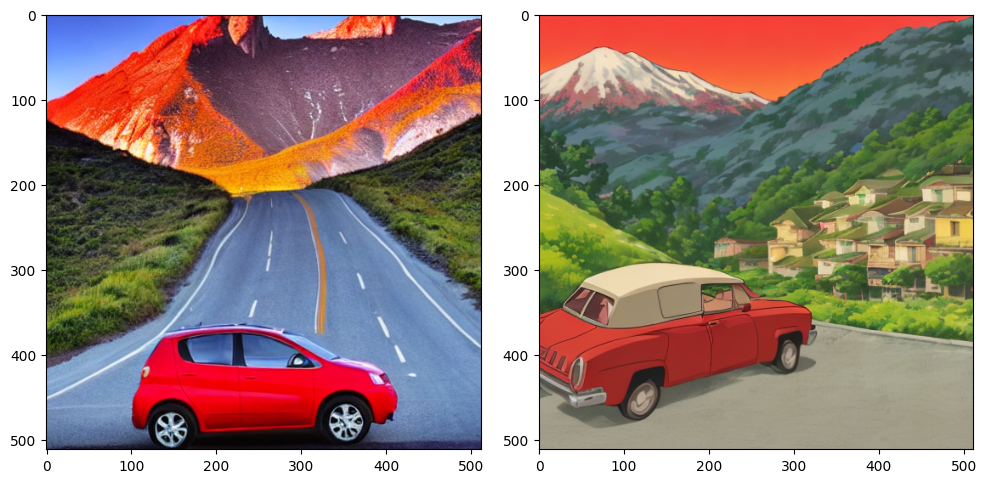

In [35]:
diff_result.show()

In [36]:
vqgan_conf_f16_16384 = utils.load_config(vqgan_conf_file)
vqgan = utils.load_vqgan(vqgan_conf_f16_16384, ckpt_path=vqgan_ckpt_file)
vqgan = vqgan.to(DEVICE).eval()
vqgan.requires_grad_(False)

model:
  base_learning_rate: 4.5e-06
  target: taming.models.vqgan.VQModel
  params:
    embed_dim: 256
    n_embed: 16384
    monitor: val/rec_loss
    ddconfig:
      double_z: false
      z_channels: 256
      resolution: 256
      in_channels: 3
      out_ch: 3
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      num_res_blocks: 2
      attn_resolutions:
      - 16
      dropout: 0.0
    lossconfig:
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
      params:
        disc_conditional: false
        disc_in_channels: 3
        disc_start: 0
        disc_weight: 0.75
        disc_num_layers: 2
        codebook_weight: 1.0

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/home/invokariman/.cache/pypoetry/virtualenvs/diffusion-ensemble-8bHjbrKS-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/invokariman/.cache/pypoetry/virtualenvs/diffusion-ensemble-8bHjbrKS-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        

In [37]:
def postprocess(images: torch.Tensor, size: int = 256) -> torch.Tensor:
  """Expects the images as (N, C, H, W) with values in [-1, 1].
  Swaps channels: (N, H, W, C), maps images in [0, 1] and applies postprocessing."""
  C, H, W = images[0].shape
  min_side = np.min([H, W])
  ratio = min_side / size

  transform = A.Compose([
    A.Resize(height=round(ratio * H), width=round(ratio * W), interpolation=cv2.INTER_LINEAR),
  ])

  processed = []
  for image in images:
    image = image.permute((1, 2, 0)).contiguous()
    processed_image = postprocess_image(image.numpy(), transform)
    processed.append(processed_image.unsqueeze(0))

  return torch.vstack(processed)


def postprocess_image(image: np.ndarray, t: Compose) -> torch.Tensor:
  # Adjust the output to [-1, 1]
  image = np.clip(image, a_min=-1.0, a_max=1.0)

  # Map from [-1, 1] to [0, 1]
  image = (image + 1.) / 2.

  # Resize the image
  image = t(image=image)['image']

  # Back to tensor
  return torch.tensor(image, dtype=torch.float32)


def preprocess(images: torch.Tensor, size: int = 256) -> torch.Tensor:
  """Expects the images as (N, H, W, C) with values in [0, 1].
  Applies preprocessing, maps images in [-1, 1] and swaps channels: (N, C, H, W)"""
  H, W, C = images[0].shape
  min_side = np.min([H, W])
  ratio = size / min_side

  transform = A.Compose([
    A.Resize(height=round(ratio * H), width=round(ratio * W), interpolation=cv2.INTER_AREA),
  ])

  processed = []
  for image in images:
    image = preprocess_image(image.numpy(), transform)
    image = image.permute((2, 0, 1)).contiguous()
    image = image.unsqueeze(0)
    processed.append(image)

  return torch.vstack(processed)


def preprocess_image(image: np.ndarray, t: Compose) -> torch.Tensor:
  # Map from [0, 1] to [-1, 1]
  image = 2. * image - 1

  # Resize the image
  image = t(image=image)['image']

  # Back to tensor
  return torch.tensor(image, dtype=torch.float32)

In [38]:
size = 256

In [39]:
postprocess(preprocess(diff_imgs, size), 128).shape

torch.Size([2, 512, 512, 3])

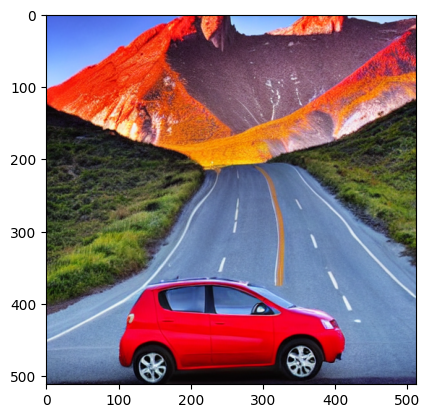

In [40]:
plt.imshow(diff_imgs[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


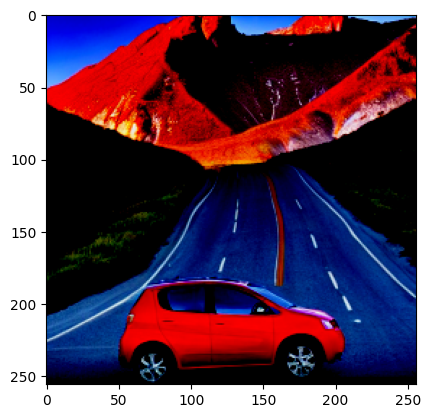

In [41]:
plt.imshow(preprocess(diff_imgs, size)[0].permute((1, 2, 0)))

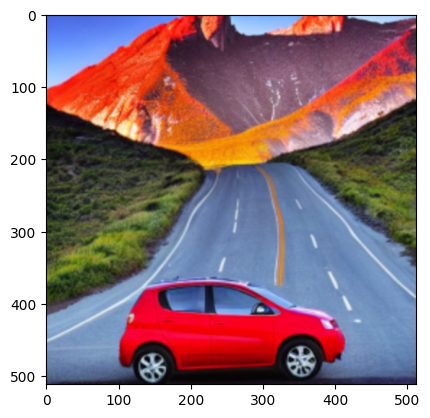

In [42]:
plt.imshow(postprocess(preprocess(diff_imgs,  size), size // 2)[0])

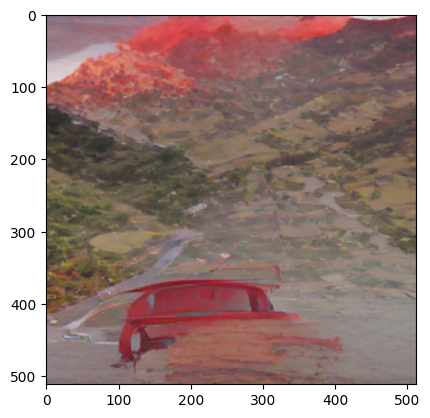

In [52]:
# Send imgs to runtime device
in_imgs = preprocess(diff_imgs, size).to(DEVICE)

# Encode to pre-quant
z = vqgan.encode_to_prequant(in_imgs)

# Compose the images in latent space
gamma = 0.5
z = gamma * z[0] + (1 - gamma) * z[1]
z = torch.unsqueeze(z, dim=0)

# Apply quantization
quant, _, _ = vqgan.quantize.forward(z)

# Decode the quantization
rec_imgs = vqgan.decode(quant)

# Go back to initial shape and interval of values
out_imgs = postprocess(rec_imgs.cpu(), size // 2)

# Display result
plt.imshow(out_imgs[0])

In [44]:
# import io
# import requests

# def download_image(url):
#     resp = requests.get(url)
#     resp.raise_for_status()
#     return PIL.Image.open(io.BytesIO(resp.content))

# img = download_image('https://heibox.uni-heidelberg.de/f/7bb608381aae4539ba7a/?dl=1')
# img = np.array(img, dtype=np.float32) / 255.

# pre = preprocess(torch.tensor(np.expand_dims(img, axis=0)))
# pre.shape

# post = postprocess(preprocess(torch.tensor(np.expand_dims(img, axis=0))))
# post.shape

# plt.imshow(post[0])

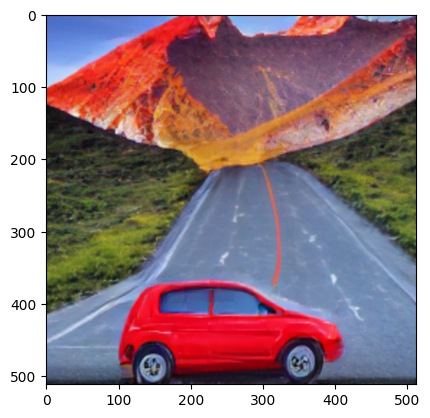

In [45]:
plt.imshow(out_imgs[0])